# Search Walk

In [107]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit.circuit.library import Diagonal

## Useful gate

In [108]:
def grover_oracle(n, sol):
    diagonal_elements = [1]*(2**n)
    diagonal_elements[sol]= -1
    oracle = Diagonal(diagonal_elements)
    oracle.name = "O$_{f}$"
    return oracle.to_gate()

In [109]:
def diffuser(n):
    qr = QuantumRegister(n)
    diffuser = QuantumCircuit(qr)
    
    diffuser.h(qr[:])
    diffuser.x(qr[:])
    diffuser.h(qr[-1])
    diffuser.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    diffuser.h(qr[-1])
    diffuser.x(qr[:])
    diffuser.h(qr[:])
    return diffuser.to_gate(label='D')

In [110]:
def increment_gate(n):
    q_r = QuantumRegister(n)
    inc = QuantumCircuit(q_r)
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i], q_r[i])
    inc.x(q_r[0])
    
    return inc.to_gate(label='INCREMENT')

In [111]:
def decrement_gate(n):
    q_r = QuantumRegister(n)
    dec = QuantumCircuit(q_r)
    
    dec.x(q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i], q_r[i])
        
    return dec.to_gate(label='DECREMENT')

In [112]:
def shift_gate(n):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    shift = QuantumCircuit(q_r_1, q_r_2,q_c)
    
    dec_j = decrement_gate(n)
    shift.append(dec_j, q_r_1[:])
    
    
    inc_j = increment_gate(n).control(1)
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    
    
    shift.append(inc_j, [q_c[1]] + q_r_1[:])

    
    dec_i = decrement_gate(n).control(1)
    shift.append(dec_i, [q_c[1]] + q_r_2[:])
    
    dec = decrement_gate(n).control(2)
    inc = increment_gate(n).control(2)
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    
    
    shift.x( q_c[1])
        
    return shift.to_gate(label='SHIFT')


In [113]:
def grover_coin():

    q_c = QuantumRegister(2)
    coin = QuantumCircuit(q_c)

    G = Operator(np.array([
        [-1, 1, 1, 1],
        [1, -1, 1, 1],
        [1, 1, -1, 1],
        [1, 1, 1, -1]
    ])/2)

    coin.unitary(G, q_c[:])
    return coin.to_gate(label='$G_{coin}$')

In [114]:
def negative_gate():

    q_c = QuantumRegister(1)
    neg = QuantumCircuit(q_c)

    N = Operator(np.array([
        [-1, 0],
        [0, -1]
        ]))

    neg.unitary(N, q_c[:])
    return neg.to_gate(label='$-I$')

In [123]:
def oracle(n,i,j):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    oracle = QuantumCircuit(q_r_1, q_r_2,q_c)
    
    i=bin(i)
    j=bin(j)
    #print(i,j)
    for k in range(n):
        if (len(i)-2-k<=0) or i[k+2]=='0':
            oracle.x(q_r_2[k])
    for k in range(n):
        if (len(j)-2-k<=0) or j[k+2]=='0':
            oracle.x(q_r_1[k])      
    
    oracle.mct(q_r_1[:]+q_r_2[:], q_c[0])
    oracle.append(negative_gate(), [q_c[0]])
    oracle.append(negative_gate(), [q_c[1]])
    
    for k in range(n):
        if (len(i)-2-k<=0) or i[k+2]=='0':
            oracle.x(q_r_2[k])
    for k in range(n):
        if (len(j)-2-k<=0) or j[k+2]=='0':
            oracle.x(q_r_1[k])  
    return oracle.to_gate(label='Oracle')


## Useful functions

In [116]:
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator).result()
    counts = result.get_counts(circuit)
    return counts

In [117]:
def grover_dec_bar(n,counts):
    t= 2**(n)
    x= range(t)
    y= [0]*t
    for num in list(counts.keys()) :
        no = int(num, base = 2)
        y[no]+= counts[num]
    y = np.array(y)/sum(y)

    plt.bar(x,y)

In [118]:
def show(n,counts, m=2):
    grid = np.zeros((2**(n),2**(n)))
    for num in list(counts.keys()) :
        i = int(num[m+1:n+m+1], base = 2)
        #i = i if i<2**(n-1) else i-(2**n)
        j = int(num[m+n+2:m+2*n+2], base = 2)
        #j = j if j<2**(n-1) else j-(2**n)
        #print(num, "i ='", i, "',j ='",j,"'", counts[num])
        #grid[i + 2**(n-1)-1,j +2**(n-1)-1]= 1024 - counts[num]
        grid[i,j]+=counts[num]
    print(grid)
    return grid

## Grover's algorithm

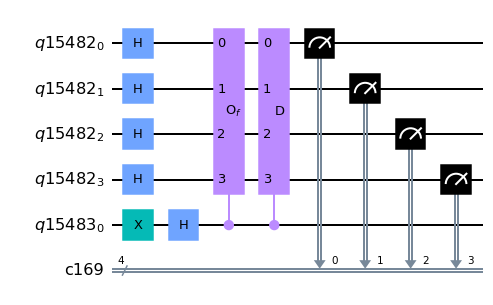

In [119]:
n=4
qr = QuantumRegister(n)
qc = QuantumRegister(1)
cr = ClassicalRegister(n)
circuit = QuantumCircuit(qr ,qc, cr)

circuit.x(qc[:])
circuit.h(qc[:])
circuit.h(qr[:])

oracle = grover_oracle(n, 2).control(1)
circuit.append(oracle, qc[:] + qr[:] )

diffuseur = diffuser(n).control(1)
circuit.append(diffuseur, qc[:] + qr[:])

circuit.measure(qr, cr)
circuit.draw(output ='mpl')

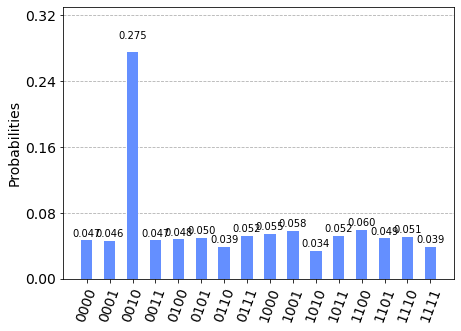

In [120]:
counts = simulate(circuit)
plot_histogram(counts)

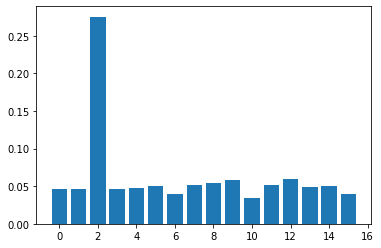

In [121]:
grover_dec_bar(n,counts)

## Search on the NxN grid

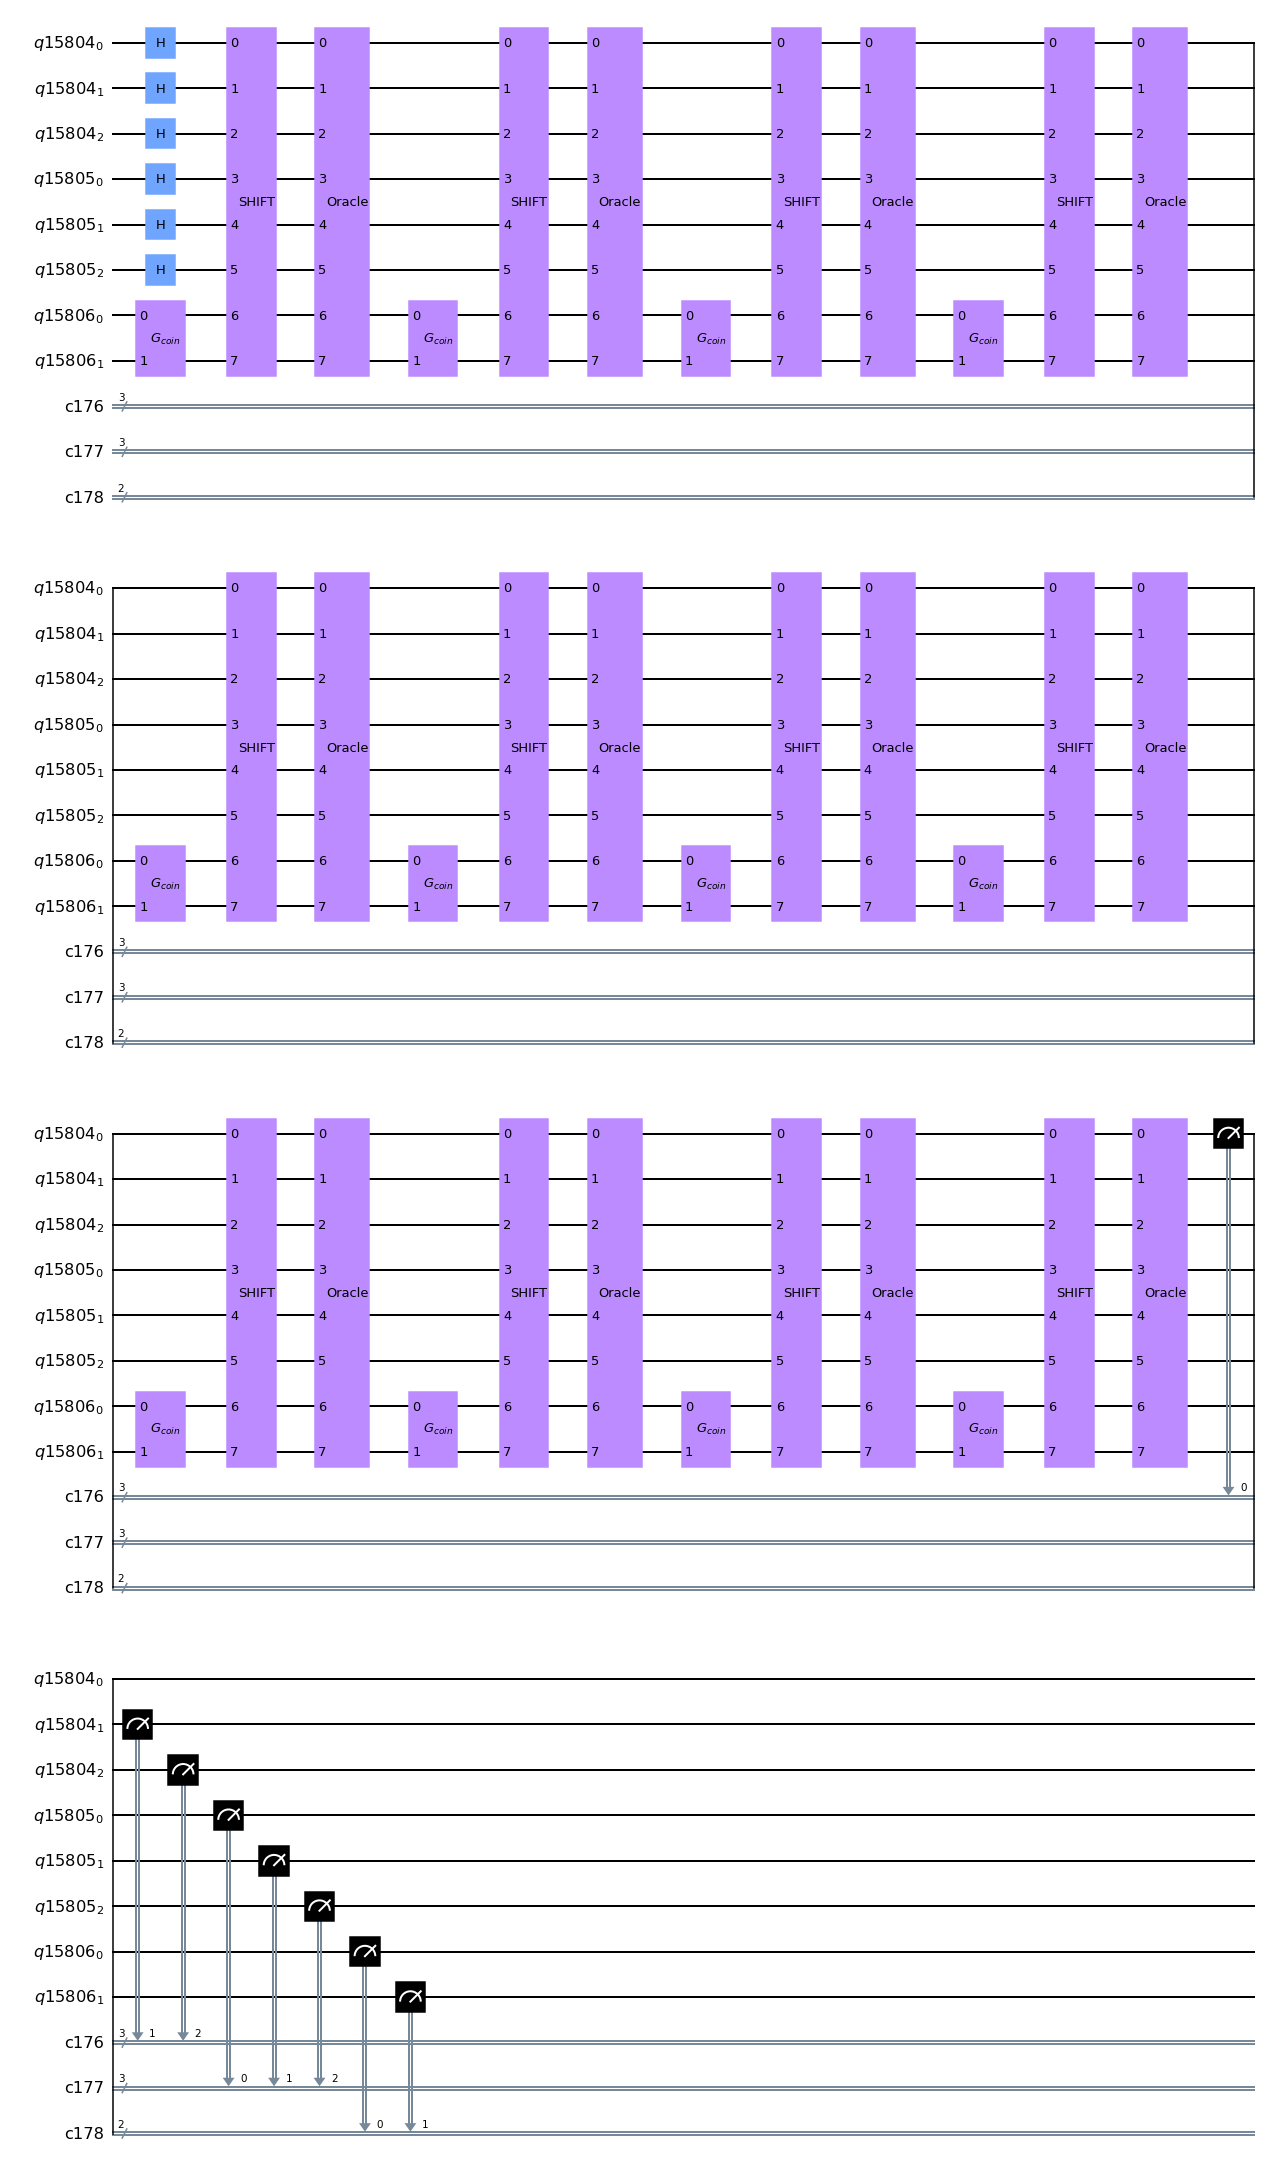

In [127]:
t = 12
n = 3
i,j = 2,2
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(2)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(2)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

circuit.h(q_reg_i[:] + q_reg_j[:])

for _ in range(t) :
    coin = grover_coin()
    circuit.append(coin, q_coin[:])
    circuit.append(shift_gate(n), q_reg_i[:] + q_reg_j[:] + q_coin[:])
    circuit.append(oracle(n,i,j), q_reg_i[:] + q_reg_j[:] + q_coin[:])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])
circuit.draw(output ='mpl')

In [131]:
counts = simulate(circuit)
#plot_histogram(counts)

[[ 4. 11.  1. 18.  5. 16. 16. 11.]
 [36. 89. 40. 17. 15. 12.  7. 28.]
 [31. 69. 29. 18. 14. 13. 14. 14.]
 [21. 24. 21. 23.  9. 14. 12. 14.]
 [18. 18. 12. 12.  8. 11. 10. 16.]
 [13. 14.  9. 15. 17. 12. 12. 14.]
 [ 6.  5.  5. 13. 17. 17. 11.  9.]
 [ 6.  6.  5. 10. 13.  9.  8.  7.]]


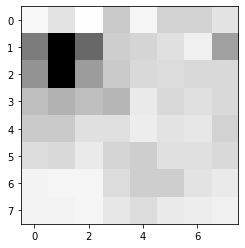

In [132]:
plt.imshow(show(n,counts)**(1.3), interpolation='nearest',vmin=0, vmax=1024/5, cmap='binary')

![SegmentLocal](grid_search.gif "segment")